In [1]:
#### Multiclass Classification: Thought Categories ####
print("Multiclass Classification: Thought Categories ")
## Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import modules for feature engineering and modelling
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
# pipeline
from imblearn.pipeline import Pipeline
# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
# cross validation and hyperparameter tuning
from sklearn.model_selection import PredefinedSplit,  cross_validate, StratifiedKFold, GridSearchCV, cross_val_score
# balancing
from imblearn.over_sampling import RandomOverSampler, SMOTE
#accuracy
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer, classification_report, average_precision_score
#feature selection
from sklearn.feature_selection import SelectKBest, chi2
from statistics import mean
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
import pickle

##### data
read_path = r"W:\WCT\04_Mind-Wandering-Labstudy\04_Daten\04_Prepared_data\00_Julia\Scripts\features_with_labels.csv"
save_path = r"W:\WCT\04_Mind-Wandering-Labstudy\04_Daten\04_Prepared_data\00_Julia\Scripts"
df = pd.read_csv(read_path)


# merge categories
# delte Category Others, because its not predictible
df = df.loc[df["Content_cat"] != 14]
# merge task- related thoughts to On-task, to get bigger classes
df["Content_Probe"] = df["Content_Probe"].replace("TRT", "On Task")
df = df.reset_index(drop = True)

# Label encoder for content probe
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df["Content_probe_categories"] = labelencoder.fit_transform(df["Content_Probe"])
print(df["Content_probe_categories"].value_counts())

# Categories
#0    452 On-Task & TRT: 44,4007858546169 , 2   396 TUT 38,89980353634578 , 1    170 TRI 16,69941060903733
def get_X_y(train):
    FEATURES = [
        'Fixation Duration Mean [ms]', 'Fixation Duration Max [ms]', 'Fixation Duration Min [ms]', 'Fixation Duration Median [ms]', 'Fixation Duration Std [ms]', 'Fixation Duration Skew [ms]', 'Fixation Duration Quantil 25 [ms]', 'Fixation Duration Quantil 75 [ms]',
        'Saccade Duration Mean [ms]', 'Saccade Duration Max [ms]', 'Saccade Duration Min [ms]', 'Saccade Duration Median [ms]', 'Saccade Duration Std [ms]', 'Saccade Duration Skew [ms]', 'Saccade Duration Quantil 25 [ms]', 'Saccade Duration Quantil 75 [ms]', 
        'Blink Duration Mean [ms]', 'Blink Duration Max [ms]', 'Blink Duration Min [ms]', 'Blink Duration Median [ms]', 'Blink Duration Std [ms]', 'Blink Duration Skew [ms]', 'Blink Duration Quantil 25 [ms]', 'Blink Duration Quantil 75 [ms]', 'Fixation Duration Kurtosis [ms]',
        'Saccade Duration Kurtosis [ms]',
        'Blink Duration Kurtosis [ms]', 
        'Fixation Saccade Ratio Mean', 'Fixation Saccade Ratio Max', 'Fixation Saccade Ratio Min', 'Fixation Saccade Ratio Median', 'Fixation Saccade Ratio Std', 'Fixation Saccade Ratio Skew', 'Fixation Saccade Ratio Kurtosis', 
        'Fixation Number', 'Blink Number', 
        'Fixation Dispersion X Mean [px]', 'Fixation Dispersion X Max [px]', 'Fixation Dispersion X Min [px]', 'Fixation Dispersion X Median [px]', 'Fixation Dispersion X Std [px]', 'Fixation Dispersion X Skew [px]', 'Fixation Dispersion X Quantil 25 [px]', 'Fixation Dispersion X Quantil 75 [px]', 
        'Fixation Dispersion Y Mean [px]', 'Fixation Dispersion Y Max [px]', 'Fixation Dispersion Y Min [px]', 'Fixation Dispersion Y Median [px]', 'Fixation Dispersion Y Std [px]', 'Fixation Dispersion Y Skew [px]', 'Fixation Dispersion Y Quantil 25 [px]', 'Fixation Dispersion Y Quantil 75 [px]', 'Fixation Dispersion X Kurtosis [px]', 'Fixation Dispersion Y Kurtosis [px]', 
        'Saccade Amplitude Mean [°]', 'Saccade Amplitude Max [°]', 'Saccade Amplitude Min [°]', 'Saccade Amplitude Median [°]', 'Saccade Amplitude Std [°]', 'Saccade Amplitude Skew [°]', 'Saccade Amplitude Quantil 25 [°]', 'Saccade Amplitude Quantil 75 [°]', 'Saccade Amplitude Kurtosis [°]',
        'Saccade Acceleration Average [°/s²] Mean', 'Saccade Acceleration Average [°/s²] Max', 'Saccade Acceleration Average [°/s²] Min', 'Saccade Acceleration Average [°/s²] Median', 'Saccade Acceleration Average [°/s²] Std', 'Saccade Acceleration Average [°/s²] Skew]', 'Saccade Acceleration Average [°/s²] Quantil 25]', 'Saccade Acceleration Average [°/s²] Quantil 75]',
        'Saccade Acceleration Peak [°/s²] Mean', 'Saccade Acceleration Peak [°/s²] Max', 'Saccade Acceleration Peak [°/s²] Min', 'Saccade Acceleration Peak [°/s²] Median', 'Saccade Acceleration Peak [°/s²] Std', 'Saccade Acceleration Peak [°/s²] Skew]', 'Saccade Acceleration Peak [°/s²] Quantil 25]', 'Saccade Acceleration Peak [°/s²] Quantil 75]', 'Saccade Deceleration Peak [°/s²] Mean', 
        'Saccade Deceleration Peak [°/s²] Max', 'Saccade Deceleration Peak [°/s²] Min', 'Saccade Deceleration Peak [°/s²] Median', 'Saccade Deceleration Peak [°/s²] Std', 'Saccade Deceleration Peak [°/s²] Skew]', 'Saccade Deceleration Peak [°/s²] Quantil 25]', 'Saccade Deceleration Peak [°/s²] Quantil 75]', 
        'Saccade Velocity Average [°/s²] Mean', 'Saccade Velocity Average [°/s²] Max', 'Saccade Velocity Average [°/s²] Min', 'Saccade Velocity Average [°/s²] Median', 'Saccade Velocity Average [°/s²] Std', 'Saccade Velocity Average [°/s²] Skew]', 'Saccade Velocity Average [°/s²] Quantil 25]', 'Saccade Velocity Average [°/s²] Quantil 75]', 
        'Saccade Velocity Peak [°/s²] Mean', 'Saccade Velocity Peak [°/s²] Max', 'Saccade Velocity Peak [°/s²] Min', 'Saccade Velocity Peak [°/s²] Median', 'Saccade Velocity Peak [°/s²] Std', 'Saccade Velocity Peak [°/s²] Skew]', 'Saccade Velocity Peak [°/s²] Quantil 25]', 'Saccade Velocity Peak [°/s²] Quantil 75]', 
        'Saccade Velocity Peak [%] Mean', 'Saccade Velocity Peak [%] Max', 'Saccade Velocity Peak [%] Min', 'Saccade Velocity Peak [%] Median', 'Saccade Velocity Peak [%] Std', 'Saccade Velocity Peak [%] Skew]', 'Saccade Velocity Peak [%] Quantil 25]', 'Saccade Velocity Peak [%] Quantil 75]', 
        'Saccade Acceleration Average [°/s²] Kurtosis', 'Saccade Acceleration Peak [°/s²] Kurtosis', 'Saccade Deceleration Peak [°/s²] Kurtosis', 'Saccade Velocity Average [°/s²] Kurtosis', 'Saccade Velocity Peak [°/s²] Kurtosis', 'Saccade Velocity Peak [%] Kurtosis', 
        'Saccade Length Mean [px]', 'Saccade Length Max [px]', 'Saccade Length Min [px]', 'Saccade Length Median [px]', 'Saccade Length Std [px]', 'Saccade Length Skew [px]]', 'Saccade Length Quantil 25 [px]]', 'Saccade Length Quantil 75 [px]]', 'Saccade Length Kurtosis [px]', 
        'Fixation Average Pupil Diameter [mm] Mean', 'Fixation Average Pupil Diameter [mm] Max', 'Fixation Average Pupil Diameter [mm] Min', 'Fixation Average Pupil Diameter [mm] Median', 'Fixation Average Pupil Diameter [mm] Std', 'Fixation Average Pupil Diameter [mm] Skew', 'Fixation Average Pupil Diameter [mm] Quantil25', 'Fixation Average Pupil Diameter [mm] Quantil75',
        'Fixation Average Pupil Diameter [mm] Kurtosis', 
        'Veregence Angles Mean [rad]', 'Veregence Angles Std [rad]', 
        'Pupil Distance Mean [px]', 'Pupil Distance Std [px]'
    ]

    GROUPS = "Participant"

    TARGET_THOUGHT_CAT = "Content_probe_categories"
    
    X = train[FEATURES]
    y_thoughts_cat = train[TARGET_THOUGHT_CAT]

    groups = train[GROUPS]

    return X, y_thoughts_cat, groups

X, y, groups = get_X_y(df)

#testing
#A, b, groups = get_X_y(df)
#X = A.head(100)
#y = b.head(100)

# Transform y to one-hot encoding format
lb = LabelBinarizer()
y_onehot = lb.fit_transform(y)

#XGBoost Pipeline
imputer =  SimpleImputer(fill_value='missing')
scaler = StandardScaler()
# Balancing
#over = SMOTE(random_state= 4) 
#over = RandomOverSampler(random_state=4)

#compute class weights 
#class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y)

## class1 is the biggest, we want to give less weight to this one
#class_0_weight = class_weights[1] / class_weights[0]
#class_2_weight = class_weights[1] / class_weights[2]

xgboost =   xgb.XGBClassifier()
steps = [('imputer', imputer), ('scaler',scaler), ('over', None), ('xgboost', xgboost)]
pipe_xgboost = Pipeline(steps=steps)


# defining parameter range
param_grid_xgboost= {
            #balancing method
            'over': [SMOTE(random_state= 4)],
            # Subsample ratio of the training instances, or the proportion of samples used to train each tree
            "xgboost__subsample": [0.8], 
            #Maximum depth of each decision tree in the ensemble
            "xgboost__max_depth": [6], 
            #Number of trees in the ensemble
            "xgboost__n_estimators": [100],
            #Subsample ratio of columns when constructing each tree. 
            "xgboost__colsample_bytree": [0.1],
            }       
                          
num_classes = 3
inner_cv = StratifiedKFold(n_splits=num_classes, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=num_classes, shuffle=True, random_state=42)

# Define the list of scoring metrics to compute
# Define scorer functions to calculate f1 score for each class separately
recall_per_class = {'recall_score_class{}'.format(i): make_scorer(recall_score, average=None, labels=[i]) for i in range(num_classes)}
f1_per_class = {'f1_score_class{}'.format(i): make_scorer(f1_score, average=None, labels=[i]) for i in range(num_classes)}
percision_per_class = {'precision_score_class{}'.format(i): make_scorer(precision_score, average=None, labels=[i]) for i in range(num_classes)}

# define Macro scores- how good are the prediction for all three classes 
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'recall_macro':make_scorer(recall_score, average='macro'),
    'precision_macro':  make_scorer(precision_score, average='macro'),
}
# merge the dictonaries
scoring.update(recall_per_class)
scoring.update(f1_per_class)
scoring.update(percision_per_class)

# Nested CV with parameter optimization
# The inner split is used to tune the hyperparameters of the model, and the outer split is used to estimate the performance of the model on new, unseen data

# The inner loop of cross-validation is used to tune the hyperparameters of the model on the training set. 
# This is done by splitting the training set into a further set of training and validation sets, 
# and evaluating the model's performance on the validation set for each combination of hyperparameters. This allows you to select the best hyperparameters for the model.
clf = GridSearchCV(estimator=pipe_xgboost,
                    param_grid=param_grid_xgboost, 
                    cv=inner_cv,
                    scoring = 'f1_macro',
                    refit = True
                    )

#The outer loop of cross-validation is used to estimate the performance of the model on new, unseen data.
nested_score = cross_validate(clf, 
                    X=X, 
                    y= y, 
                    cv=outer_cv,
                    scoring=scoring,
                    return_estimator=True
                    )


# Get the best estimator from the GridSearchCV object for each outer fold
estimator = nested_score['estimator'][0]
# extract best estimator
best_estimator = estimator.best_estimator_
#Get the estimator object from the cross-validation results
estimator = nested_score['estimator'][0]
## extract best estimator
best_estimator = estimator.best_estimator_
##extract best parameters
best_params_xgboost = best_estimator.named_steps['xgboost'].get_params()
#
## extract the crossvalidation results from the estsimator object
estimator_results = estimator.cv_results_



Multiclass Classification: Thought Categories 
0    452
2    396
1    170
Name: Content_probe_categories, dtype: int64


In [2]:
feature_names = [
        'Fixation Duration Mean [ms]', 'Fixation Duration Max [ms]', 'Fixation Duration Min [ms]', 'Fixation Duration Median [ms]', 'Fixation Duration Std [ms]', 'Fixation Duration Skew [ms]', 'Fixation Duration Quantil 25 [ms]', 'Fixation Duration Quantil 75 [ms]',
        'Saccade Duration Mean [ms]', 'Saccade Duration Max [ms]', 'Saccade Duration Min [ms]', 'Saccade Duration Median [ms]', 'Saccade Duration Std [ms]', 'Saccade Duration Skew [ms]', 'Saccade Duration Quantil 25 [ms]', 'Saccade Duration Quantil 75 [ms]', 
        'Blink Duration Mean [ms]', 'Blink Duration Max [ms]', 'Blink Duration Min [ms]', 'Blink Duration Median [ms]', 'Blink Duration Std [ms]', 'Blink Duration Skew [ms]', 'Blink Duration Quantil 25 [ms]', 'Blink Duration Quantil 75 [ms]', 'Fixation Duration Kurtosis [ms]',
        'Saccade Duration Kurtosis [ms]',
        'Blink Duration Kurtosis [ms]', 
        'Fixation Saccade Ratio Mean', 'Fixation Saccade Ratio Max', 'Fixation Saccade Ratio Min', 'Fixation Saccade Ratio Median', 'Fixation Saccade Ratio Std', 'Fixation Saccade Ratio Skew', 'Fixation Saccade Ratio Kurtosis', 
        'Fixation Number', 'Blink Number', 
        'Fixation Dispersion X Mean [px]', 'Fixation Dispersion X Max [px]', 'Fixation Dispersion X Min [px]', 'Fixation Dispersion X Median [px]', 'Fixation Dispersion X Std [px]', 'Fixation Dispersion X Skew [px]', 'Fixation Dispersion X Quantil 25 [px]', 'Fixation Dispersion X Quantil 75 [px]', 
        'Fixation Dispersion Y Mean [px]', 'Fixation Dispersion Y Max [px]', 'Fixation Dispersion Y Min [px]', 'Fixation Dispersion Y Median [px]', 'Fixation Dispersion Y Std [px]', 'Fixation Dispersion Y Skew [px]', 'Fixation Dispersion Y Quantil 25 [px]', 'Fixation Dispersion Y Quantil 75 [px]', 'Fixation Dispersion X Kurtosis [px]', 'Fixation Dispersion Y Kurtosis [px]', 
        'Saccade Amplitude Mean [°]', 'Saccade Amplitude Max [°]', 'Saccade Amplitude Min [°]', 'Saccade Amplitude Median [°]', 'Saccade Amplitude Std [°]', 'Saccade Amplitude Skew [°]', 'Saccade Amplitude Quantil 25 [°]', 'Saccade Amplitude Quantil 75 [°]', 'Saccade Amplitude Kurtosis [°]',
        'Saccade Acceleration Average [°/s²] Mean', 'Saccade Acceleration Average [°/s²] Max', 'Saccade Acceleration Average [°/s²] Min', 'Saccade Acceleration Average [°/s²] Median', 'Saccade Acceleration Average [°/s²] Std', 'Saccade Acceleration Average [°/s²] Skew]', 'Saccade Acceleration Average [°/s²] Quantil 25]', 'Saccade Acceleration Average [°/s²] Quantil 75]',
        'Saccade Acceleration Peak [°/s²] Mean', 'Saccade Acceleration Peak [°/s²] Max', 'Saccade Acceleration Peak [°/s²] Min', 'Saccade Acceleration Peak [°/s²] Median', 'Saccade Acceleration Peak [°/s²] Std', 'Saccade Acceleration Peak [°/s²] Skew]', 'Saccade Acceleration Peak [°/s²] Quantil 25]', 'Saccade Acceleration Peak [°/s²] Quantil 75]', 'Saccade Deceleration Peak [°/s²] Mean', 
        'Saccade Deceleration Peak [°/s²] Max', 'Saccade Deceleration Peak [°/s²] Min', 'Saccade Deceleration Peak [°/s²] Median', 'Saccade Deceleration Peak [°/s²] Std', 'Saccade Deceleration Peak [°/s²] Skew]', 'Saccade Deceleration Peak [°/s²] Quantil 25]', 'Saccade Deceleration Peak [°/s²] Quantil 75]', 
        'Saccade Velocity Average [°/s²] Mean', 'Saccade Velocity Average [°/s²] Max', 'Saccade Velocity Average [°/s²] Min', 'Saccade Velocity Average [°/s²] Median', 'Saccade Velocity Average [°/s²] Std', 'Saccade Velocity Average [°/s²] Skew]', 'Saccade Velocity Average [°/s²] Quantil 25]', 'Saccade Velocity Average [°/s²] Quantil 75]', 
        'Saccade Velocity Peak [°/s²] Mean', 'Saccade Velocity Peak [°/s²] Max', 'Saccade Velocity Peak [°/s²] Min', 'Saccade Velocity Peak [°/s²] Median', 'Saccade Velocity Peak [°/s²] Std', 'Saccade Velocity Peak [°/s²] Skew]', 'Saccade Velocity Peak [°/s²] Quantil 25]', 'Saccade Velocity Peak [°/s²] Quantil 75]', 
        'Saccade Velocity Peak [%] Mean', 'Saccade Velocity Peak [%] Max', 'Saccade Velocity Peak [%] Min', 'Saccade Velocity Peak [%] Median', 'Saccade Velocity Peak [%] Std', 'Saccade Velocity Peak [%] Skew]', 'Saccade Velocity Peak [%] Quantil 25]', 'Saccade Velocity Peak [%] Quantil 75]', 
        'Saccade Acceleration Average [°/s²] Kurtosis', 'Saccade Acceleration Peak [°/s²] Kurtosis', 'Saccade Deceleration Peak [°/s²] Kurtosis', 'Saccade Velocity Average [°/s²] Kurtosis', 'Saccade Velocity Peak [°/s²] Kurtosis', 'Saccade Velocity Peak [%] Kurtosis', 
        'Saccade Length Mean [px]', 'Saccade Length Max [px]', 'Saccade Length Min [px]', 'Saccade Length Median [px]', 'Saccade Length Std [px]', 'Saccade Length Skew [px]]', 'Saccade Length Quantil 25 [px]]', 'Saccade Length Quantil 75 [px]]', 'Saccade Length Kurtosis [px]', 
        'Fixation Average Pupil Diameter [mm] Mean', 'Fixation Average Pupil Diameter [mm] Max', 'Fixation Average Pupil Diameter [mm] Min', 'Fixation Average Pupil Diameter [mm] Median', 'Fixation Average Pupil Diameter [mm] Std', 'Fixation Average Pupil Diameter [mm] Skew', 'Fixation Average Pupil Diameter [mm] Quantil25', 'Fixation Average Pupil Diameter [mm] Quantil75',
        'Fixation Average Pupil Diameter [mm] Kurtosis', 
        'Veregence Angles Mean [rad]', 'Veregence Angles Std [rad]', 
        'Pupil Distance Mean [px]', 'Pupil Distance Std [px]'
    ]

In [3]:
available_importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
f = 'gain'
importances = best_estimator.named_steps['xgboost'].get_booster().get_score(importance_type= f)



In [4]:
feature_importances_data = {'Importances': importances.values(), 'Name': feature_names}
df_importances_gain = pd.DataFrame(feature_importances_data)
df_importances_gain.sort_values(by=['Importances'], ascending= False).head(50)

,Importances,Name
10,1.378469,Saccade Duration Min [ms]
77,1.278676,Saccade Acceleration Peak [°/s²] Quantil 25]
4,1.080684,Fixation Duration Std [ms]
9,0.997162,Saccade Duration Max [ms]
123,0.989515,Saccade Length Quantil 25 [px]]
64,0.974603,Saccade Acceleration Average [°/s²] Max
15,0.973527,Saccade Duration Quantil 75 [ms]
87,0.967337,Saccade Velocity Average [°/s²] Mean
127,0.937788,Fixation Average Pupil Diameter [mm] Max
134,0.931799,Fixation Average Pupil Diameter [mm] Kurtosis


In [5]:
df_importances_gain.sort_values(by=['Importances'], ascending= False).head(50)#.plot()

,Importances,Name
10,1.378469,Saccade Duration Min [ms]
77,1.278676,Saccade Acceleration Peak [°/s²] Quantil 25]
4,1.080684,Fixation Duration Std [ms]
9,0.997162,Saccade Duration Max [ms]
123,0.989515,Saccade Length Quantil 25 [px]]
64,0.974603,Saccade Acceleration Average [°/s²] Max
15,0.973527,Saccade Duration Quantil 75 [ms]
87,0.967337,Saccade Velocity Average [°/s²] Mean
127,0.937788,Fixation Average Pupil Diameter [mm] Max
134,0.931799,Fixation Average Pupil Diameter [mm] Kurtosis


In [6]:
df_importances_gain.sort_values(by=['Importances'], ascending= False).tail(50)#.plot()

,Importances,Name
53,0.438353,Fixation Dispersion Y Kurtosis [px]
60,0.436749,Saccade Amplitude Quantil 25 [°]
111,0.433634,Saccade Acceleration Average [°/s²] Kurtosis
65,0.430852,Saccade Acceleration Average [°/s²] Min
66,0.424111,Saccade Acceleration Average [°/s²] Median
35,0.419482,Blink Number
3,0.418297,Fixation Duration Median [ms]
12,0.415678,Saccade Duration Std [ms]
72,0.411981,Saccade Acceleration Peak [°/s²] Max
56,0.410789,Saccade Amplitude Min [°]


In [7]:
# Plot feature importances
importances = df_importances_gain.sort_values(by=['Importances'], ascending= False).head(10)['Importances']
names = df_importances_gain.sort_values(by=['Importances'], ascending= False).head(10)['Name']


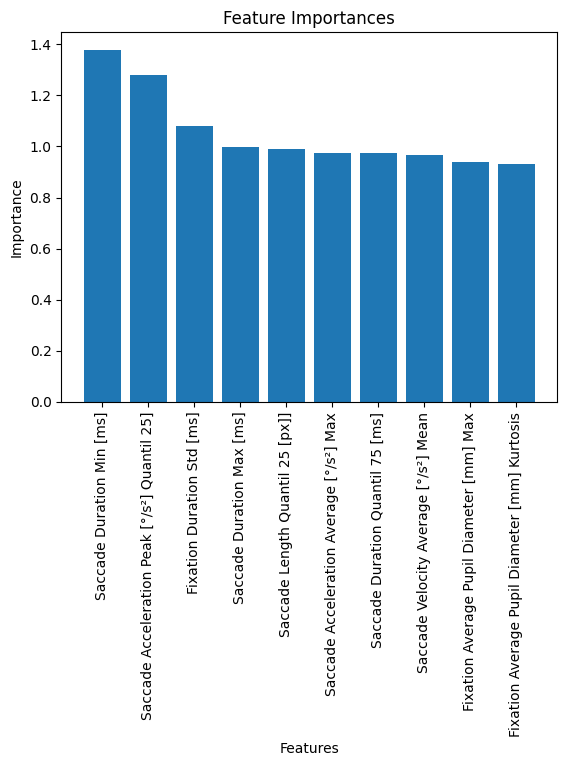

In [8]:
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()